In [1]:
import sys
sys.path.append("../")
from libraries.dataManipulation import *
from libraries.gridManipulation import *
from csv import DictReader
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import warnings
warnings.filterwarnings(action='ignore')
import time
import ast

In [2]:
from sociophysicsDataHandler import SociophysicsDataHandler

In [57]:
def to_unix_timestamp(datetime_utc):
    return datetime_utc.timestamp()
    return (datetime_utc - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [4]:
#Check for train
#TODO
def check_train(timestamp):
    df_train_present = train_data[(train_data['departure_unix'] > t) & (train_data['arrival_unix'] < t)]
    train_present_top = False
    train_present_bottom = False

In [154]:
def get_train_data():
    train_data = SociophysicsDataHandler()
    train_data.fetch_prorail_train_information(station='ehv')
    train_data = train_data.train_information
    
    train_data['arrival_unix'] = train_data['arrival_time'].apply(to_unix_timestamp)
    train_data['departure_unix'] = train_data['departure_time'].apply(to_unix_timestamp)
    
    train_data_no_nan = train_data.dropna()
    #limit rows to 1 row per train (individual door information deleted)
    train_data_filtered = train_data_no_nan.drop_duplicates('arrival_time')
    
    unix_timestamp_day_start =  min(people_in_dictionary_on.keys())
    unix_timestamp_day_end =  max(people_in_dictionary_on.keys())
    
    day_train_data = train_data_filtered[(train_data_filtered['arrival_unix'] > unix_timestamp_day_start) & (train_data_filtered['departure_unix'] < unix_timestamp_day_end)]
    day_train_data = day_train_data.reset_index(drop=True)
    
    day_train_data = day_train_data.assign(train_position=lambda x: np.where(x['door_y'] > 2500, 'top', 'bottom'))
    day_train_data = day_train_data.drop(columns=['door_no', 'door_x', 'door_y','station'])
    
    return train_data_filtered

In [155]:
df = get_train_data()

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/ehv_train_information_pss.parquet
data fetched. Accessible as <this-object>.train_information


In [166]:
df[df['date'] == datetime.date(2022, 5, 9)]

,date,station,train_number,arrival_time,departure_time,door_no,door_x,door_y,arrival_unix,departure_unix
77640,2022-05-09,Ehv,818,2022-05-09 06:32:29+02:00,2022-05-09 06:35:56+02:00,1.0,706.638444,3956.960896,1.652071e+09,1.652071e+09
77647,2022-05-09,Ehv,826,2022-05-09 08:32:26+02:00,2022-05-09 08:36:07+02:00,1.0,12979.775716,3792.220798,1.652078e+09,1.652078e+09
77652,2022-05-09,Ehv,828,2022-05-09 09:02:12+02:00,2022-05-09 09:06:02+02:00,1.0,9775.790848,3835.227307,1.652080e+09,1.652080e+09
77657,2022-05-09,Ehv,830,2022-05-09 09:32:19+02:00,2022-05-09 09:36:13+02:00,1.0,6877.388759,3874.132033,1.652082e+09,1.652082e+09
77663,2022-05-09,Ehv,832,2022-05-09 10:01:41+02:00,2022-05-09 10:06:05+02:00,1.0,13575.790848,3784.220595,1.652083e+09,1.652084e+09
...,...,...,...,...,...,...,...,...,...,...
78228,2022-05-09,Ehv,6469,2022-05-09 20:08:32+02:00,2022-05-09 20:15:55+02:00,1.0,4650.000000,-8595.970132,1.652120e+09,1.652120e+09
78237,2022-05-09,Ehv,6473,2022-05-09 21:06:41+02:00,2022-05-09 21:16:01+02:00,1.0,12150.000000,-8696.641273,1.652123e+09,1.652124e+09
78246,2022-05-09,Ehv,6477,2022-05-09 22:07:34+02:00,2022-05-09 22:16:02+02:00,1.0,18750.000000,-8785.231877,1.652127e+09,1.652127e+09
78252,2022-05-09,Ehv,6481,2022-05-09 23:09:30+02:00,2022-05-09 23:16:05+02:00,1.0,4150.000000,-8589.258722,1.652131e+09,1.652131e+09


In [139]:
t = 1649046710
df_train_present = df[(df['departure_unix'] > t) & (df['arrival_unix'] < t)]

df_train_present

,date,train_number,arrival_unix,departure_unix,train_position
0,2022-04-04,818,1.649047e+09,1.649047e+09,top


In [7]:
#Spawn people
def spawn_people(timestamp):
    global current_ID, simulation_tuple
    if timestamp in people_in_dictionary_off:
        spawn_zones = people_in_dictionary_off[timestamp]
        for zone in spawn_zones:
            zone = int(zone)
            offboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,True,False,timestamp,zone]])
            
            density[zone_to_coordinate(zone)] += 1/zone_area
            current_ID += 1
    
    if timestamp in people_in_dictionary_on:
        spawn_zones = people_in_dictionary_on[timestamp]
        for zone in spawn_zones:
            zone = int(zone)
            onboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,False,True,timestamp,zone]])
            
            density[zone_to_coordinate(zone)] += 1/zone_area
            current_ID += 1

In [8]:
#Put an obstacle in a zone by making the probability of going to that zone 0
def block_zone(markov_matrix, zone):
    m = markov_matrix.copy()
    m[zone] = 0
    return m
    

In [9]:
#Get a library of people spawning
def get_spawn_lib(onboarding_offboarding):
    
    if onboarding_offboarding == 'onboarding':
        df = pd.read_csv('../people_input/incoming_people_entering_5_0.csv', sep = ';', header = None)
        df = df.set_index(0)
        spawn_dict = df.to_dict()[1]
        for key in spawn_dict.keys():
            spawn_dict[key] = ast.literal_eval(spawn_dict[key])
            
    elif onboarding_offboarding == 'offboarding':
        df = pd.read_csv('../people_input/incoming_people_offboarding_5_0.csv', sep = ';', header = None)
        df = df.set_index(0)
        spawn_dict = df.to_dict()[1]
        for key in spawn_dict.keys():
            spawn_dict[key] = ast.literal_eval(spawn_dict[key])
        
    else:
        print("Error: " + onboarding_offboarding + " is not a valid input")
        return None
    
    return spawn_dict
    

In [10]:
#Determine the density based on the locations of people
#DEPRECATED
def calculate_density():
    locs = {**onboarding_people_locs,**offboarding_people_locs}
    
    density = density_0
    
    #Cycle through all the people in the locs dictionary
    for i in locs.keys():
        density[zone_to_coordinate(locs[i])] += 1/zone_area
        
    return density

In [11]:
#Convert the density matrix into a 3x3 matrix of surrounding zone densities
#The area of 5x5 squares around the midpoint will be taken into account by averaging them into the 3x3 matrix
#The midpoint will be a tuple of the form (zone_row,zone_column)
def get_density_matrix(density_matrix, current_zone):
    density_matrix_5 = np.zeros([5,5])
    midpoint = zone_to_coordinate(current_zone)

    for i in range(5):
        for j in range(5):
            coords = ( min(max(midpoint[0]+i-2,0),zone_rows-1), min(max(midpoint[1]+j-2,0),zone_columns-1) )
            density_matrix_5[i,j] = density[coords]
    
    #Convert the 5x5 density matrix into a 3x3 one
    density_matrix_5_3 = np.zeros([5,3])
    
    density_matrix_5_3[:,0] = 0.3 * density_matrix_5[:,0] + 0.7 * density_matrix_5[:,1]
    density_matrix_5_3[:,1] = density_matrix_5[:,2]
    density_matrix_5_3[:,2] = 0.7 * density_matrix_5[:,3] + 0.3 * density_matrix_5[:,4]
    
    density_matrix_3 = np.zeros([3,3])
    
    density_matrix_3[0,:] = 0.3 * density_matrix_5_3[0,:] + 0.7 * density_matrix_5_3[1,:]
    density_matrix_3[1,:] = density_matrix_5_3[2,:]
    density_matrix_3[2,:] = 0.7 * density_matrix_5_3[3,:] + 0.3 * density_matrix_5_3[4,:]
    
    #People shouldn't be repelled from their own zones, so make the middle denisty zero
    density_matrix_3[1,1] = 0
    
    density_matrix_3 = density_matrix_3.flatten() #Put the matrix in the flattened form
    
    #Add zeros for void_zones density
    for i in range(void_zones):
        density_matrix_3 = np.append(density_matrix_3,0)
    
    return density_matrix_3 

In [12]:
#Get a 3x3 probability matrix around the midpoint of moving to the neighbouring zone or staying
def get_probability_matrix(markov_matrix, current_zone):
    prob_matrix = np.zeros(9 + void_zones)
    midpoint = zone_to_coordinate(current_zone)
    
    k = 0
    for i in range(3):
        for j in range(3):
            x = midpoint[1] + j-1
            y = midpoint[0] + i-1
            
            if not (0 <= x < zone_columns):
                prob_matrix[k] = 0
                k += 1
    
            elif not (0 <= y < zone_rows):
                prob_matrix[k] = 0
                k += 1
                
            else:
                coords = (y,x)
                zone_nr = coordinate_to_zone(coords)
                prob_matrix[k] = markov_matrix[zone_nr][current_zone]
                k += 1
    
    for i in range(void_zones):
        prob_matrix[9+i] = markov_matrix[n_zones + i][current_zone]
        
    return prob_matrix

In [13]:
#Convert zone number to coordinate in zone grid
def zone_to_coordinate(zone_nr):
    x_pos = math.floor(zone_nr/zone_rows)
    y_pos = zone_nr % zone_rows
    return (y_pos,x_pos) #Return in the form of row nr., column nr., which corresponds to y,x

In [14]:
#Convert coordinate 
def coordinate_to_zone(coord):
    x = coord[1] #equivalent to column nr.
    y = coord[0] #equivalent to row nr.
    return x*zone_rows + y
    

In [15]:
#Convert density/probability array index to zone offset
def array_index_to_zone_offset(index):
    x_offset = index % 3 -1 #Column nr. offset
    y_offset = math.floor(index/3) - 1 #Row nr. offset
    return (y_offset, x_offset)

In [34]:
#Function to relate density to probability adjustment factor
#Input is a array of densities
def density_probability_function(density):
    factor = 1 - ( 0.9 - 0.9 * np.power( math.e,-2*(density/max_density) ) )
    return factor

In [17]:
#Adjust the probabilities of moving between zones according to density in neighbouring zones
#The input probabilities is an 1D array for several zones
def adjust_probability(probabilities, density):
    probabilities = probabilities * density_probability_function( density )
    probabilities[probabilities<0] = 0
    return probabilities

In [18]:
#Get a new zone for a person a markov matrix and a randomly generated number
def get_new_zone(current_zone, markov_matrix):
    
    #Check if someone is in the disappearing zone
    if (current_zone >= n_zones):
        return current_zone
    
    #Get the probabilities for the zone and apply the randomness
    probabilities_unadjusted = get_probability_matrix(markov_matrix,current_zone)
    densities = get_density_matrix(density,current_zone) #Densities in the adjacent zones
    probabilities = adjust_probability(probabilities_unadjusted, densities)

    i = 0 #Iterator to keep track of which column/movement must be selected
    if (sum(probabilities) == 0):
        rand  = 0
    else:
        rand = random.random() * sum(probabilities)
        
    while rand > probabilities[i]:
        rand -= probabilities[i]
        i += 1
    
    if (i > 8):
        return n_zones
    
    coord_offset = array_index_to_zone_offset(i)
    current_coord = zone_to_coordinate(current_zone)
    new_coord = (current_coord[0] + coord_offset[0], current_coord[1] + coord_offset[1])
    new_zone = coordinate_to_zone(new_coord)
    if (new_zone < 0):
        new_zone = 0
    return new_zone
    

In [19]:
#Change the position of people according to the corresponding markov matrix
def move():
    global simulation_tuple
    
    #Loop through offboarders with markov matrix adjusted for density
    markov_matrix = markov_matrix_offboarding
    
    for zone in blocked_zones:
        markov_matrix = block_zone(markov_matrix, zone)
    
    for offboarder_ID, current_zone in offboarding_people_locs.items():
        
        new_zone = get_new_zone(current_zone, markov_matrix)
        
        offboarding_people_locs[offboarder_ID] = new_zone
        simulation_tuple.extend([[offboarder_ID,True,False,time,new_zone]])
        
        density[zone_to_coordinate(current_zone)] -= 1/zone_area
        density[zone_to_coordinate(new_zone)] += 1/zone_area
    
    #Loop through onboarders with markov matrix adjusted for density and whether there is a train
    if train_present_top:
        markov_matrix = markov_matrix_onboarding_train_top
    elif train_present_bottom:
        markov_matrix = markov_matrix_onboarding_train_bottom
    else:
        markov_matrix = markov_matrix_onboarding_no_train
    
    for zone in blocked_zones:
        markov_matrix = block_zone(markov_matrix, zone)
    
    for onboarder_ID, current_zone in onboarding_people_locs.items():
            
        new_zone = get_new_zone(current_zone, markov_matrix)

        onboarding_people_locs[onboarder_ID] = new_zone
        simulation_tuple.extend([[onboarder_ID,False,True,time,new_zone]])
        
        density[zone_to_coordinate(current_zone)] -= 1/zone_area
        density[zone_to_coordinate(new_zone)] += 1/zone_area
         

In [38]:
%%time

#Number of zones
zone_rows = 14
zone_columns = 67
n_zones = zone_rows * zone_columns
void_zones = 1 #Number of zones that people can disappear to

#Variables that have to be determined in different steps
markov_matrix_offboarding = pd.read_csv('../matrix_generator/results/offboarding/average.csv', header=None)
markov_matrix_onboarding_no_train =  pd.read_csv('../matrix_generator/results/onboarding_no_train/average.csv', header=None)
markov_matrix_onboarding_train_top =  pd.read_csv('../matrix_generator/results/onboarding_top/average.csv',header=None)
markov_matrix_onboarding_train_bottom =  pd.read_csv('../matrix_generator/results/onboarding_bottom/average.csv',header=None)
density_influence_table = None
people_in_dictionary_off = get_spawn_lib('offboarding') #[50,51,52,53,54,55]}
people_in_dictionary_on = get_spawn_lib('onboarding') #[1,2,3,4,5,6]}

#Information about people
current_ID = 1000 #People will also have an ID in the simulation, only a different one
offboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
onboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values

#Density information
max_density = 5 #TODO
zone_area = 2 #TODO
#Set all densities to 0
density_0 = np.zeros([zone_rows,zone_columns+1])
density = density_0 #Dictionary with zone IDs as keys and density as values

#Create dataframe to store the data over time
simulation_tuple = ([[0,False,False,0,0]])

#Nudges
blocked_zones = [1,2,3]

#Get train departure and arrival information
train_data = get_train_data()

train_present_top = False
train_present_bottom = False

#Initialize variables
time =  list(people_in_dictionary_off.keys())[150] #Starting time of simulation
sim_duration = 600 #How long the simulation lasts in seconds


# SIMULATE 

#Start looping
for i in range(sim_duration):
    
    check_train(time)
    
    move()
    
    spawn_people(time)
    
    time += 1

simulation_df = pd.DataFrame(list(simulation_tuple), columns = ['ID','Offboarding','Onboarding','Time','Zone'])
simulation_df = simulation_df.drop(0)
simulation_df['x_pos'] = simulation_df['Zone'].divide(zone_rows).apply(np.floor)
simulation_df['y_pos'] = (simulation_df['Zone']).mod(zone_rows)
simulation_df.head()

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/ehv_train_information_pss.parquet
data fetched. Accessible as <this-object>.train_information
Wall time: 21.2 s


,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos
1,1000,True,False,1649039576,587,41.0,13
2,1001,True,False,1649039576,447,31.0,13
3,1000,True,False,1649039577,572,40.0,12
4,1001,True,False,1649039577,446,31.0,12
5,1002,True,False,1649039577,601,42.0,13


In [21]:
simulation_df.to_csv('test_results.csv',index = False)

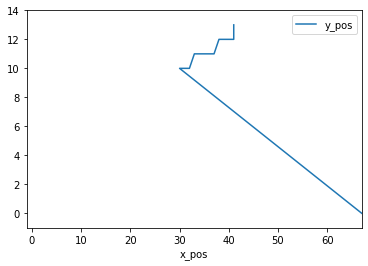

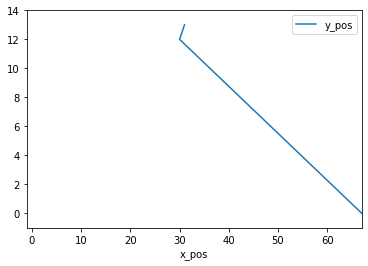

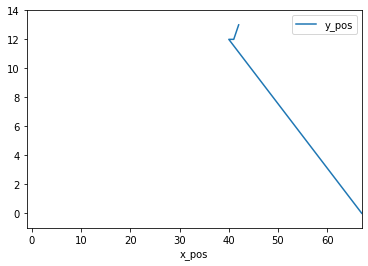

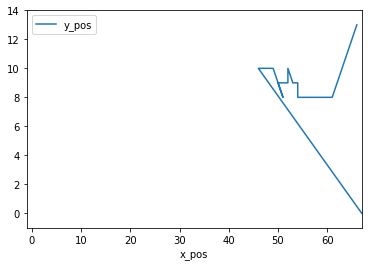

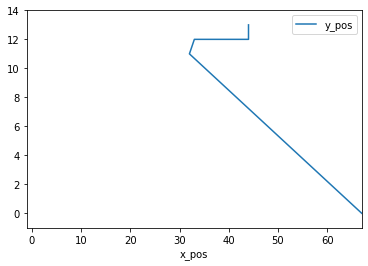

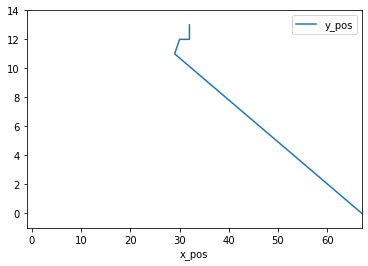

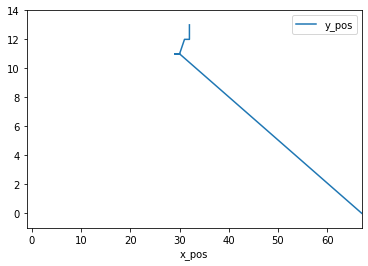

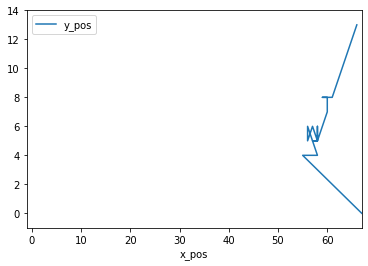

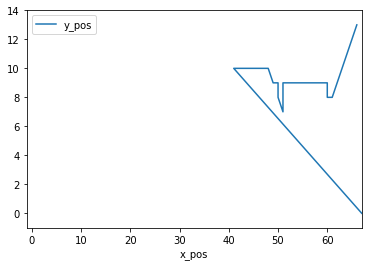

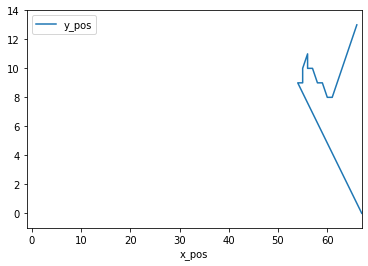

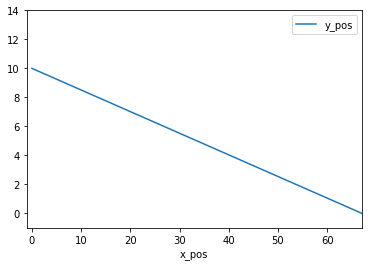

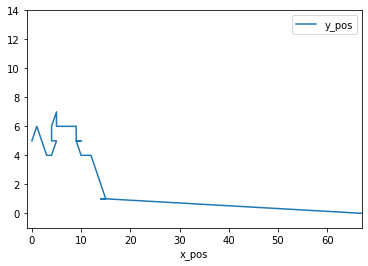

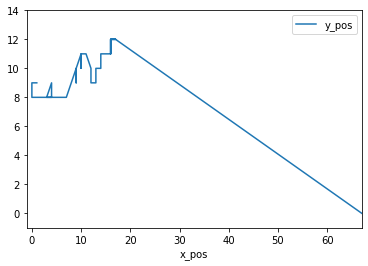

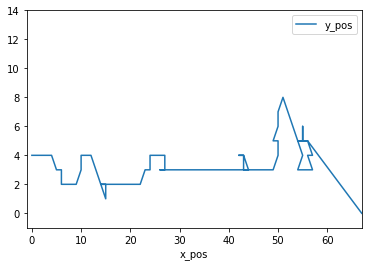

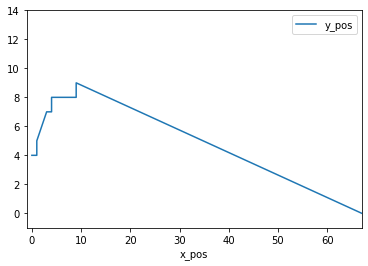

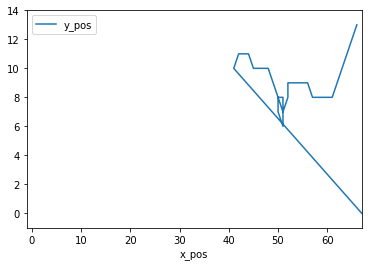

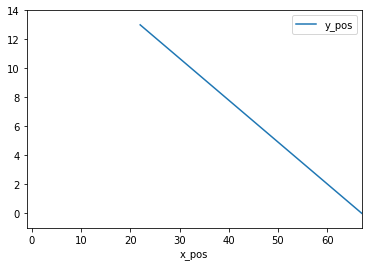

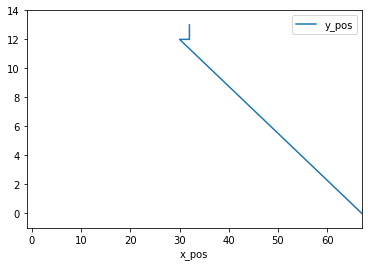

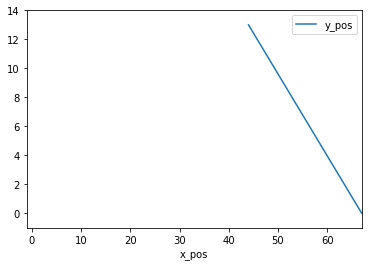

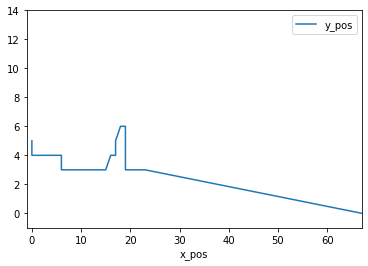

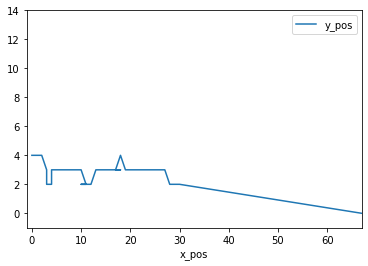

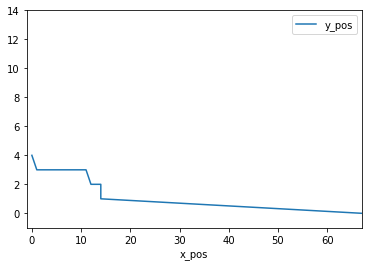

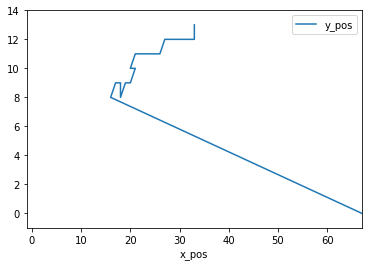

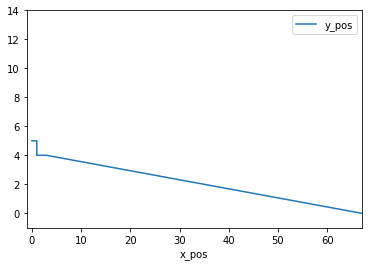

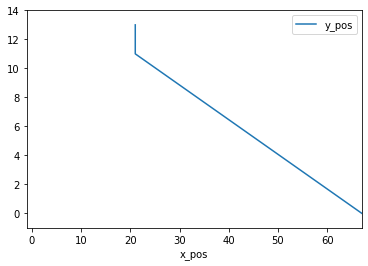

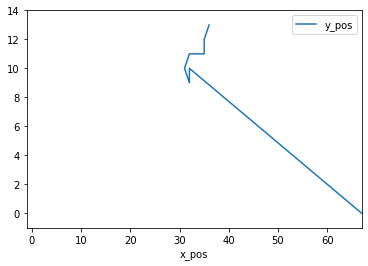

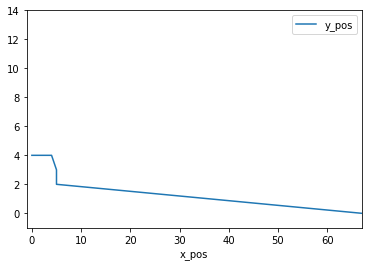

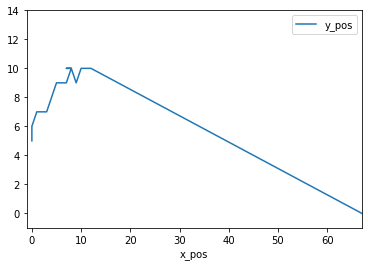

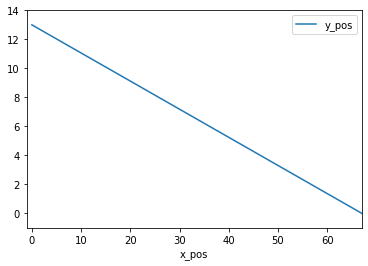

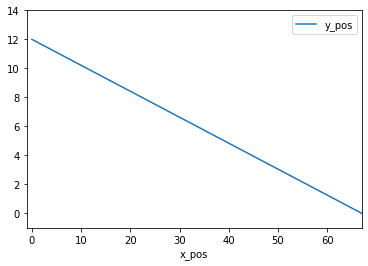

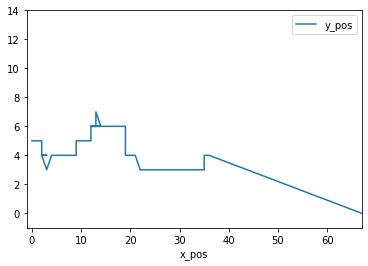

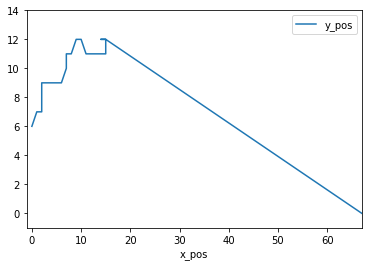

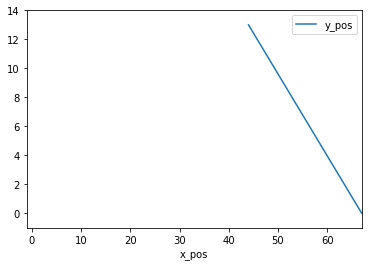

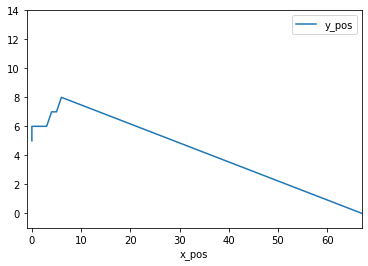

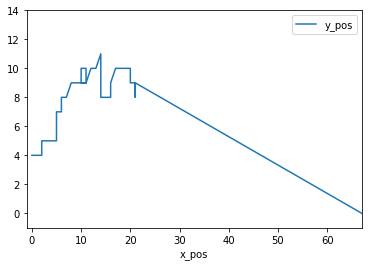

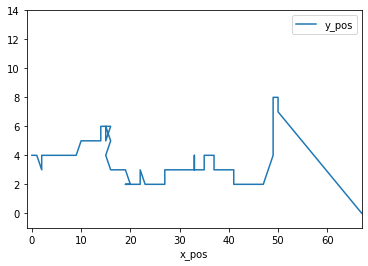

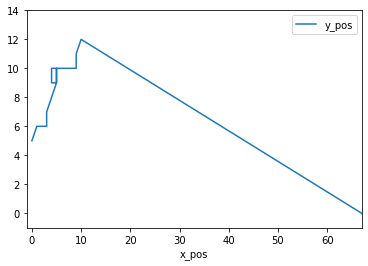

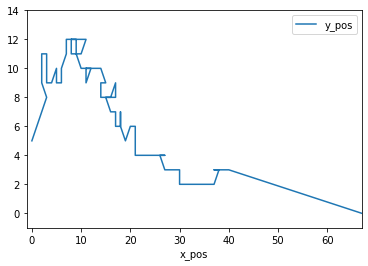

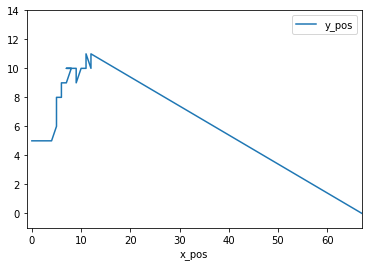

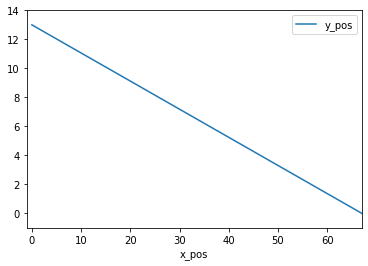

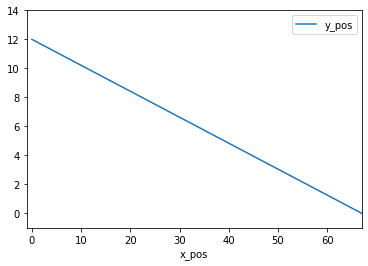

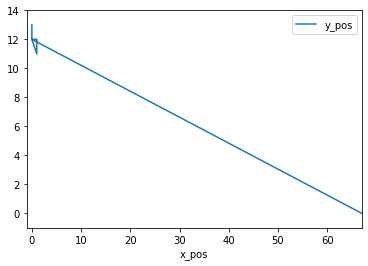

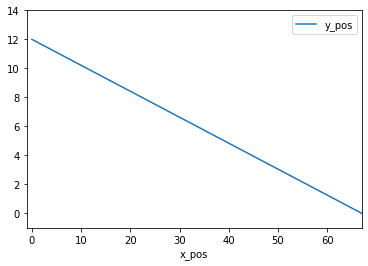

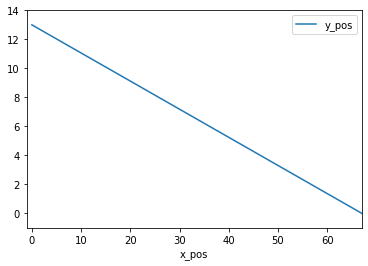

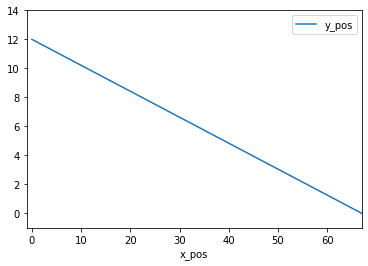

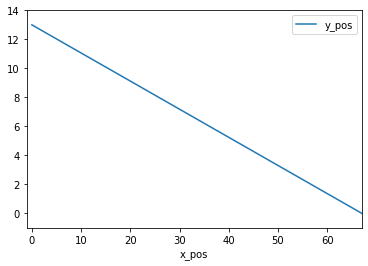

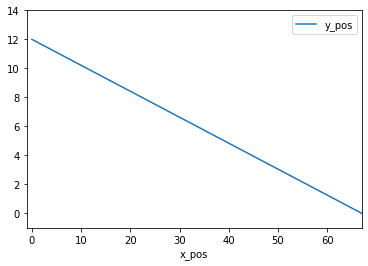

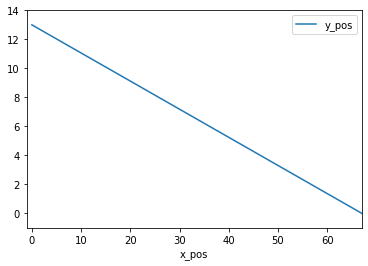

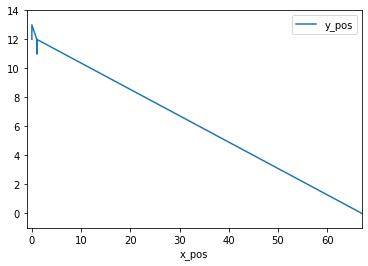

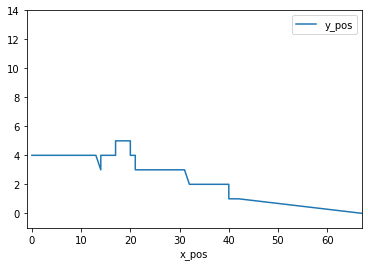

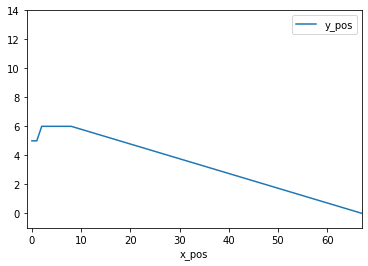

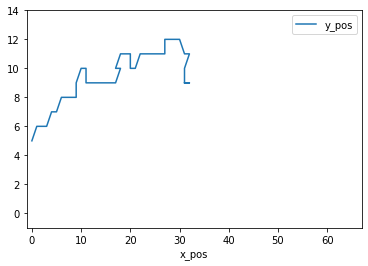

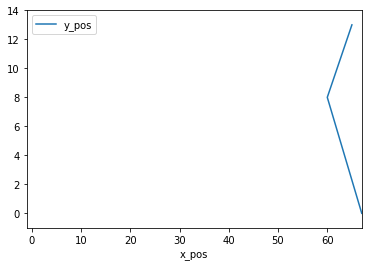

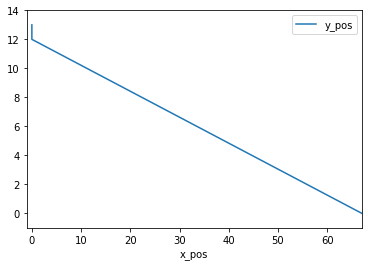

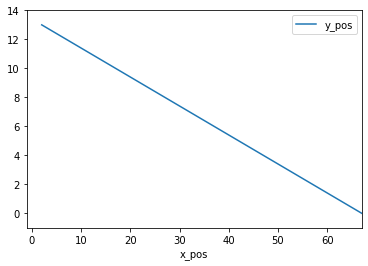

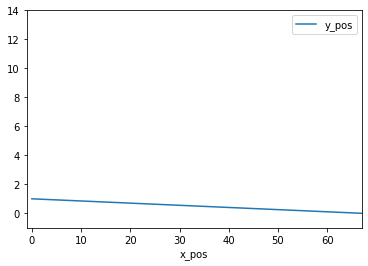

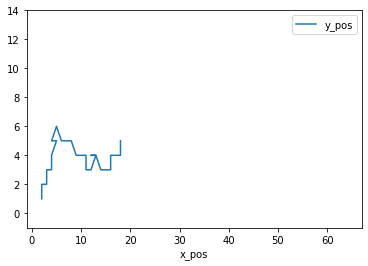

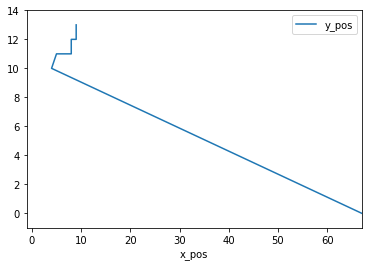

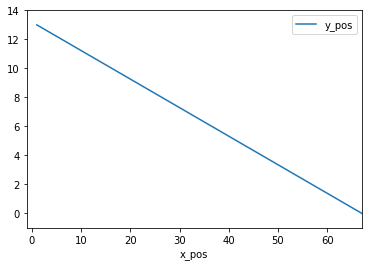

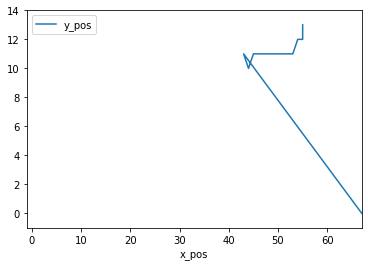

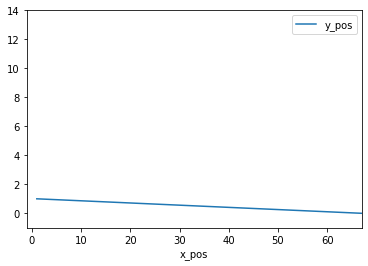

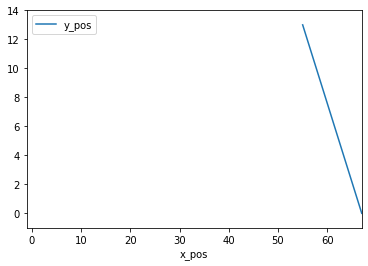

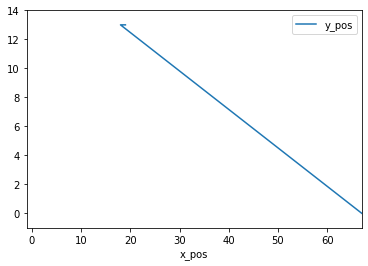

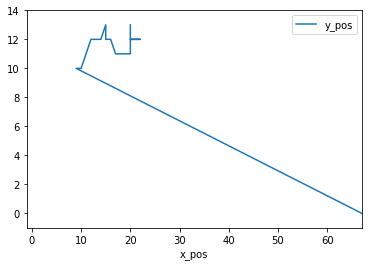

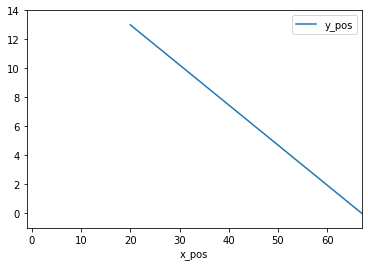

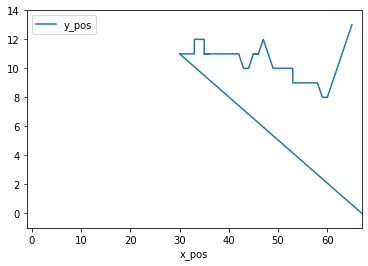

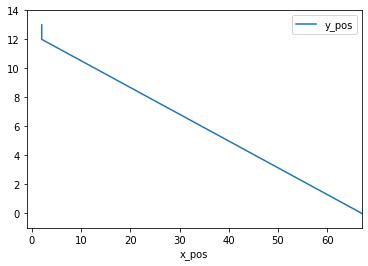

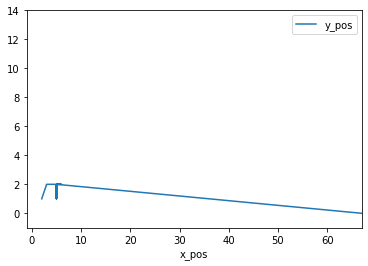

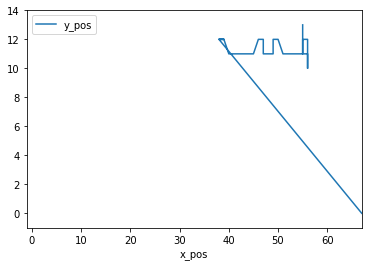

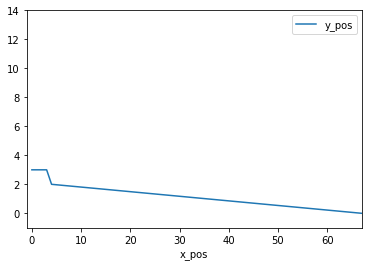

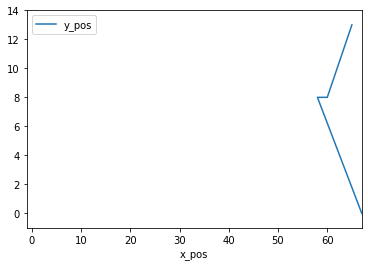

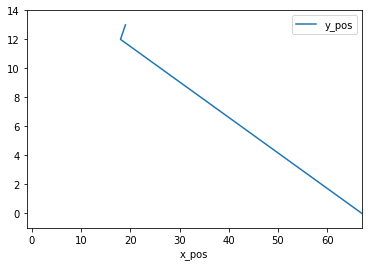

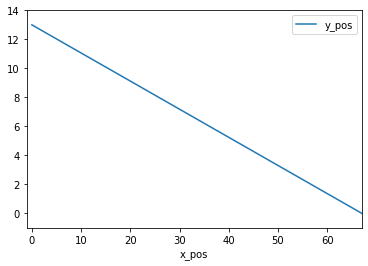

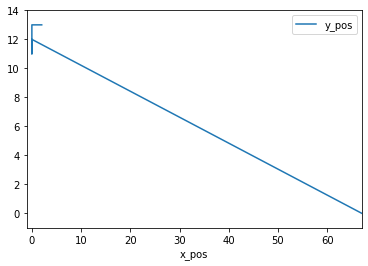

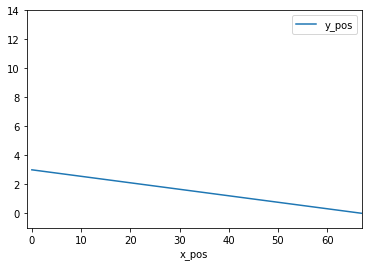

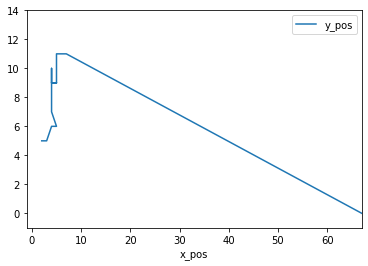

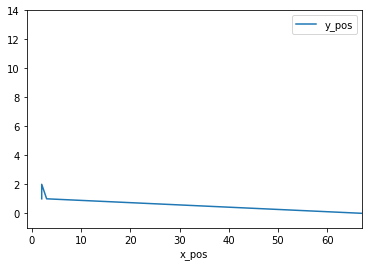

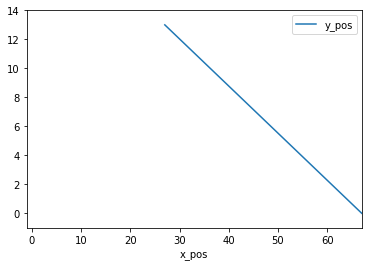

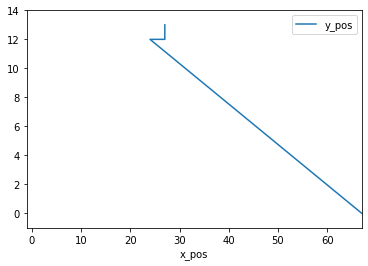

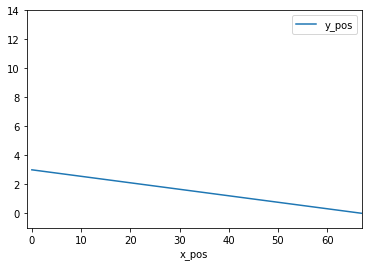

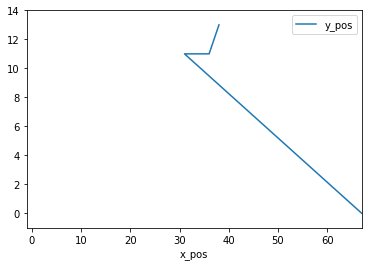

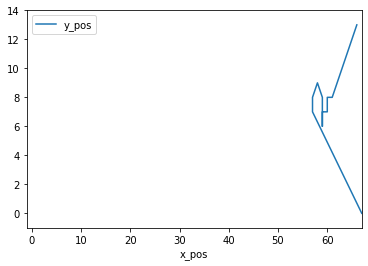

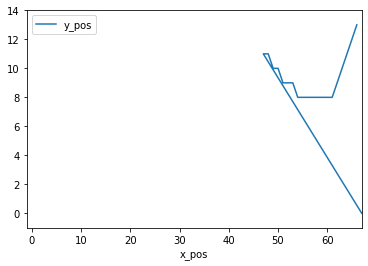

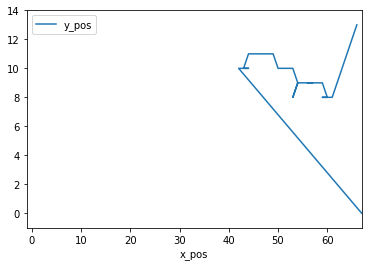

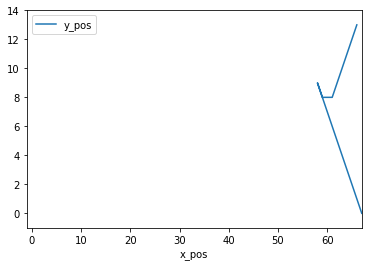

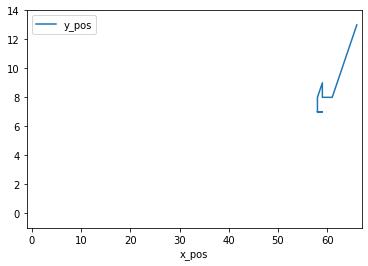

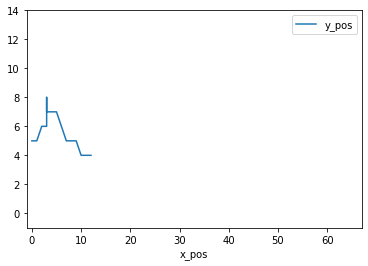

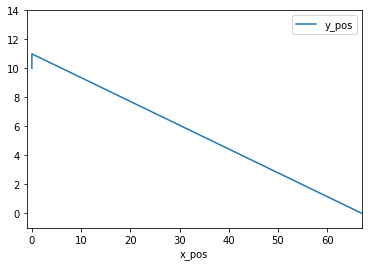

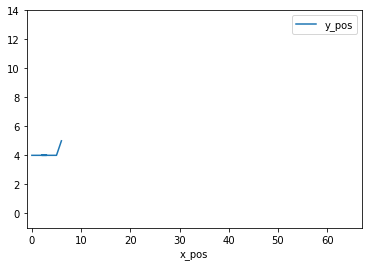

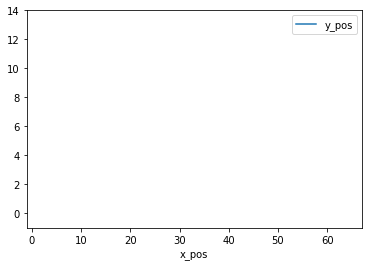

In [22]:
ax = simulation_df.groupby('ID').plot('x_pos','y_pos', xlim = [-1, 67], ylim = [-1,14]);

In [41]:
density_probability_function(np.array([0,1,2,3,4,5]))

array([1.        , 0.70328804, 0.50439607, 0.37107479, 0.28170687,
       0.22180175])

In [25]:
markov_matrix_onboarding_no_train

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.488778,0.046887,0.000141,0.002208,1.323489e-25,4.949861e-31,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273497
2,0.0,0.054759,0.303201,0.094050,0.007838,1.613706e-03,3.189532e-04,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157958
3,0.0,0.003353,0.042372,0.549408,0.014076,5.956578e-03,2.331897e-03,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166189
4,0.0,0.000002,0.000277,0.042569,0.237154,7.371265e-02,1.161184e-03,0.000352,2.195569e-27,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
935,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
936,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
937,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
